In [1]:
# Get packages
using CSV, DataFrames, wgregseq, CairoMakie, Statistics, DelimitedFiles, Dates, Colors, FASTX, BioSequences, StatsBase, ProgressMeter

# Set colors and plotting style
wgregseq.plotting_style.default_makie!()
update_theme!(Theme(font = "Lato", titlefont="Lato"))
colors_dict = wgregseq.plotting_style.my_color_dict
colors = [colors_dict["blue1"], colors_dict["orange1"], colors_dict["green1"]]

3-element Vector{String}:
 "#324fa2"
 "#f47c20"
 "#a8cf38"

In [11]:
gc_dict = Dict(
    1 => "M9 + 0.5% Glucose",
    2 => "M9 + 0.5% Xylose",
    3 => "M9 + 0.5% Arabinose",
    5 => "M9 + 0.5% Glucose + 2.5mM Sodium Salicytate",
    6 => "M9 + 0.5% Glucose + 5% Ethanol",
    7 => "M9 + 0.5% Glucose + Stationary Phase (1d)",
    10 => "M9 + 0.5% Glucose + 2mg/L Ampicillin",
    12 => "M9 + 0.5% Glucose + H2O2 (0.1 mM)",
    13 => "LB",
)

Dict{Int64, String} with 9 entries:
  5  => "M9 + 0.5% Glucose + 2.5mM Sodium Salicytate"
  13 => "LB"
  6  => "M9 + 0.5% Glucose + 5% Ethanol"
  7  => "M9 + 0.5% Glucose + Stationary Phase (1d)"
  2  => "M9 + 0.5% Xylose"
  10 => "M9 + 0.5% Glucose + 2mg/L Ampicillin"
  12 => "M9 + 0.5% Glucose + H2O2 (0.1 mM)"
  3  => "M9 + 0.5% Arabinose"
  1  => "M9 + 0.5% Glucose"

In [5]:
df_map = CSV.read(
    "../../../data/barcodes/20220514_mapping/mapped_barcodes.csv", 
    DataFrame, 
);

# Filter out unnannotad sequences
df_map = df_map[df_map.name .!= "*", :]

# Filter out non-unique barcodes
gdf = groupby(df_map[(df_map.map_count .> 2), :], :barcode)
_df = DataFrame()
for df in gdf
    if nrow(df) == 1
        append!(_df, df)
    end
end
df_map = copy(_df);

# Get twist order to get wild type sequences
df_seqs = wgregseq.utils.import_twist_order("../../../data/twist_orders/2022-02-15_twist_order.csv")
df_wt = df_seqs[1:1501:119*1501, :];
insertcols!(df_wt, 4, :promoter_seq => [string(x[27:186]) for x in df_wt.sequence])

df_wt.promoter_seq |> unique |> length
df_map = leftjoin(df_map, rename(df_wt[!, [:promoter, :promoter_seq]], :promoter => :name), on="name")
rename!(df_map, :promoter_seq => :wt_seq);

In [6]:
df_sites = CSV.read("binding_sites.txt", DataFrame)

Row,promoter,TF,start,end,type,evidence
,String7,String15,Int64,Int64,String7,String7
1,aceBp,IclR,-29,-23,rep,high
2,aceBp,IclR,-45,-31,rep,high
3,aceBp,IclR,-56,-50,rep,high
4,aceBp,IclR,-107,-101,rep,high
5,aceBp,IHF,-78,-66,act,high
6,aceBp,CRP,-41,-20,rep,low
7,acrAp,PhoP,24,40,rep,low
8,acrAp,MprA,-26,-6,rep,low
9,acrAp,Envr/AcrR,-34,-11,rep,high


In [7]:
function get_dataset(i)
    df_DNA = CSV.read(
        "../../../data/extracted_barcodes/20230907_barcode/D$(i)_collapsed.txt", 
        DataFrame, 
        ignorerepeated=true, 
        delim=" ", 
        header=["ct_0", "barcode"]
    )
    # import RNA
    df_RNA = CSV.read(
        "../../../data/extracted_barcodes/20230907_barcode/R$(i)_collapsed.txt", 
        DataFrame, 
        ignorerepeated=true, 
        delim=" ", 
        header=["ct_1", "barcode"]
    )
    
    # merge DNA and RNA reads
    df = outerjoin(df_DNA, df_RNA, on=:barcode)
    
    # replace missing reads with 0
    replace!(df.ct_0, missing => 0)
    replace!(df.ct_1, missing => 0)
    
    # identify promoter sequences
    df = innerjoin(df, df_map, on=:barcode)
    
    # compute total counts
    insertcols!(df, 1, :ct => df.ct_0 .+ df.ct_1)
    insertcols!(df, 1, :relative_counts => (df.ct_1 .+ 1) ./ (df.ct_0 .+ 1))
    
    # Turn sequences into integer
    insertcols!(df, 3, :int_promoter => wgregseq.footprints.make_int.(df[:, :promoter]))
    insertcols!(df, 3, :int_wt => wgregseq.footprints.make_int.(df[:, :wt_seq]));
    return df
end

get_dataset (generic function with 1 method)

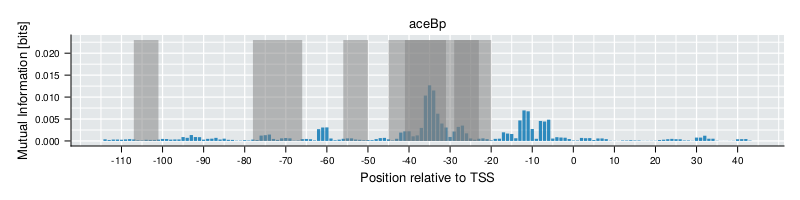

In [10]:
df = get_dataset(1)

prom = "aceBp"

fig = Figure(resolution=(800, 200))
x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== prom, :])
ax2 = Axis(fig[1, 1], xticks=-110:10:40, xlabel="Position relative to TSS", ylabel="Mutual Information [bits]", title=prom)
d = 1
barplot!(ax2, -115+d:44-d, [mean(x2[i-d:i+d]) for i in 1+d:160-d])

for site in eachrow(df_sites[df_sites.promoter .== prom, :])
    band!(ax2, [site["start"], site["end"]], [0, 0], [maximum(x2), maximum(x2)], color=("gray", 0.5))
end

fig

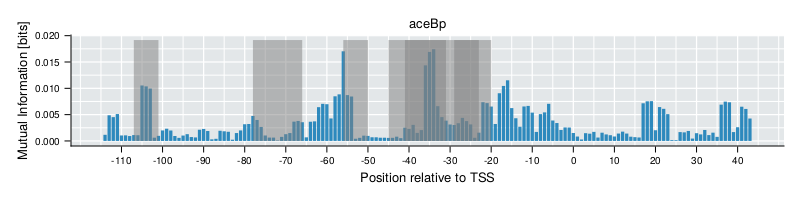

In [15]:
df = get_dataset(7)

prom = "aceBp"

fig = Figure(resolution=(800, 200))
x2 = wgregseq.footprints.mutual_information_mutation(df[df.name .== prom, :])
ax2 = Axis(fig[1, 1], xticks=-110:10:40, xlabel="Position relative to TSS", ylabel="Mutual Information [bits]", title=prom)
d = 1
x_mean = [mean(x2[i-d:i+d]) for i in 1+d:160-d]
barplot!(ax2, -115+d:44-d, x_mean)

for site in eachrow(df_sites[df_sites.promoter .== prom, :])
    band!(ax2, [site["start"], site["end"]], [0, 0], 1.1 .* [maximum(x_mean), maximum(x_mean)], color=("gray", 0.5))
end

fig